# Saint Louis Crime
## DATA620 Project 2
### Bryant Chang, Thomas Detzel, Erik Nylander

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
import networkx.algorithms.bipartite as bp

## Introduction and Findings

*Note: To hide/show code in this notebook, use the </> toggle button in the toolbar.*

In the 1990s Rick Rosenfeld and Norm White used police records to collect data on crime in St. Louis. They began with five homicides and recorded the names of all the individuals who had been involved as victims, suspects or witnesses. They then explored the files and recorded all the other crimes in which those same individuals appeared. This snowball process was continued until they had data on 557 crime events. Those events involved 870 participants of which: 569 appeared as victims 682 appeared as suspects 195 appeared as witnesses, and 41 were dual (they were recorded both as victims and suspects in the same crime). Their data appear, then, as an 870x557, individual-by-crime event matrix. Victims are coded as 1, suspects as 2, witnesses as 3 and duals as 4.

In addition Rosenfeld and White recorded the sex of each individual. The data can be found [here](http://konect.uni-koblenz.de/networks/moreno_crime) in a compressed format. We have uploaded the necessary files to the projects GitHub site to facilitate the analysis.

We used the island method (Tsvetovat, Maksim; Kouznetsov, Alexander. Social Network Analysis for Startups, O'Reilly Media) to identify connected subgroups in the data. Findings identified a small network involving Luella Katz, who was active as a suspect, victim or witness in 18 crimes. Katz also is connected to other highly active suspects. We identified Katz by using the island method and reducing the overall network from 829 unique persons to 28 who were connected in 12 groups by association in different crimes either as suspects, victims or witnesses. 


## 1. Crime Data Import, Exploration

The crime data set that we have chosen to use is split amongst a number of different files. There are four main files that we worked with, the data on crimes, the data on the relationships of the people to the crimes, the names of the individuals, and the sex of the individuals. The following code imports the various files and uses the dataframe features of *pandas* to create our crime data set that is needed to build our graph.

### 1.1 Basic nodes, edges
A Person is conncted to a Crime and has a relationship of either Suspect, Victim, Witness or Victim-Suspect.

In [2]:
# loading crime data
data_crime = "https://raw.githubusercontent.com/eriknylander99/DATA620_Group_Projects/master/data/moreno_crime/out.moreno_crime_crime"
crime = pd.read_csv(data_crime, delim_whitespace=True, header=None, skiprows=[0,1], names=['Person', 'Crime'])
# loading relationship data
data_rel = "https://raw.githubusercontent.com/eriknylander99/DATA620_Group_Projects/master/data/moreno_crime/rel.moreno_crime_crime.person.role"
crime['Relationship'] = pd.read_csv(data_rel, header=None)

crime.head()

,Person,Crime,Relationship
0,1,1,Suspect
1,1,2,Victim
2,1,3,Victim
3,1,4,Suspect
4,2,5,Victim


### 1.2 Total number of Persons

In [3]:
# Total number of people
len(crime.Person.unique())

829

### 1.3 Total number of Crimes

In [4]:
# Total number of crimes
len(crime.Crime.unique())

551

### 1.4 Table of Relationships

In [5]:
# checking relationships 
rels = crime.groupby('Relationship')
print rels.count().iloc[:,0]

Relationship
Suspect           682
Victim            558
Victim Suspect     41
Witness           195
Name: Person, dtype: int64


### 1.5 Distribution of Crimes by Person
The vast majority of persons in the data were involved in only a single crime.

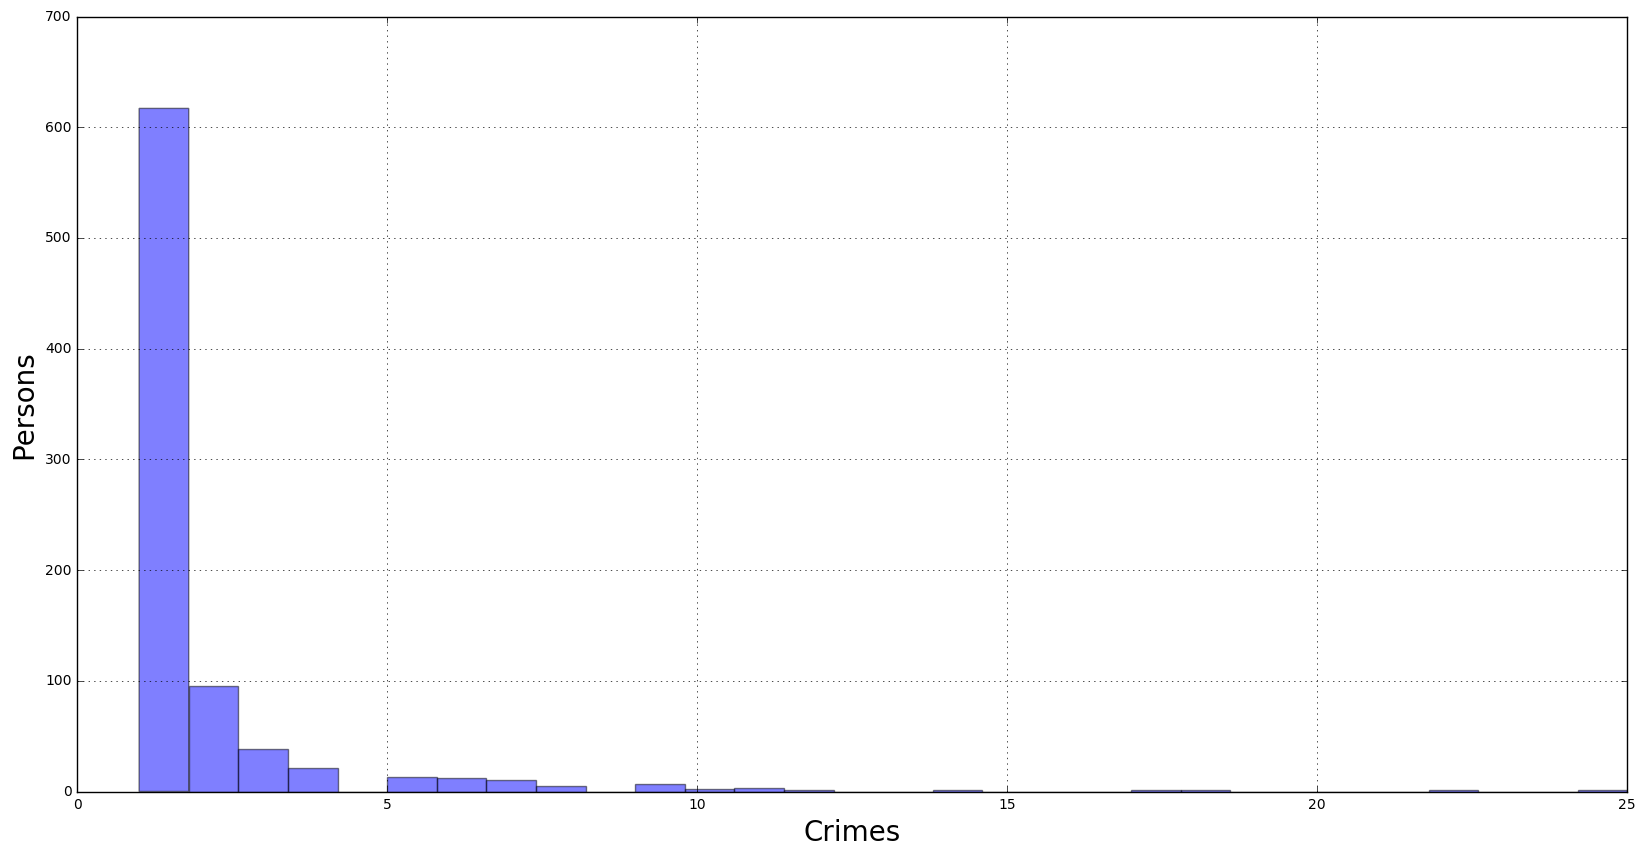

In [6]:
# crime_count histogram
crime_count = pd.DataFrame({'Crime_Count' : crime.groupby(['Person']).size()}).reset_index()
crime_count.iloc[:,1].plot.hist(alpha=0.5, bins=30)
plt.xlabel('Crimes', fontsize=20)
plt.ylabel('Persons', fontsize=20)
# plt.title('Distribution of Crimes by Person', loc='left', fontsize=24)
plt.grid(True)

plt.show()

In [7]:
## segregating attributes here to get a relationship count and a total crime count 
crime2 = crime
crime2['rel_count'] = crime2.groupby(['Person', 'Relationship'])['Crime'].transform('count')
crime2['crime_count'] = crime2.groupby(['Person'])['Crime'].transform('count')
crime2.head()

,Person,Crime,Relationship,rel_count,crime_count
0,1,1,Suspect,2,4
1,1,2,Victim,2,4
2,1,3,Victim,2,4
3,1,4,Suspect,2,4
4,2,5,Victim,4,22


### 1.6 Adding Person names, Crime ID, Relationship, Count of Relationship, Count of Crime, Sex

In [8]:
# loading name data
data_names = 'https://raw.githubusercontent.com/eriknylander99/DATA620_Group_Projects/master/data/moreno_crime/ent.moreno_crime_crime.person.name'
names = pd.read_csv(data_names, sep='\t', header=None)

# loading sex data
data_sex = 'https://raw.githubusercontent.com/eriknylander99/DATA620_Group_Projects/master/data/moreno_crime/ent.moreno_crime_crime.person.sex'
names['Sex'] = pd.read_csv(data_sex, header=None)
names.ix[names.Sex == 1, 'Sex'] = 'M'
names.ix[names.Sex == 0, 'Sex'] = 'F'

# replacing left nodes (people involved in a crime) with names and adding sex
# Right nodes stay as numbers to identify as crimes, not people
for i in range(0,len(names)):
    crime2.ix[crime2.Person == i+1, 'Sex'] = names.iloc[i][1]
    crime2.ix[crime2.Person == i+1, 'Person'] = names.iloc[i][0]
    
crime2.head()

,Person,Crime,Relationship,rel_count,crime_count,Sex
0,AbelDennis,1,Suspect,2,4,M
1,AbelDennis,2,Victim,2,4,M
2,AbelDennis,3,Victim,2,4,M
3,AbelDennis,4,Suspect,2,4,M
4,AbramsChad,5,Victim,4,22,M


### 1.7 Suspect, Victim, Witness Overlap

Complicating the analysis is that many of the victims have also been suspsects in different crimes, and vice versa. Many victims are also listed as witnesses. Identifying a true criminal network, then, will require filtering out suspects. Nearly a fourth of all suspects were also crime victims. For instance, Luella Katz, whom we will identify later as part of a criminal network, is involved with 18 crimes – 15 as a suspect, twice as a victim and once as a witness.

In [9]:
## make sets of the suspect, victim and witness nodes, then compute overlap
suspects = set(crime2[crime2['Relationship'] == "Suspect"].iloc[:, 0].unique())
victims = set(crime2[crime2['Relationship'] == 'Victim'].iloc[:,0].unique())
witness = set(crime2[crime2['Relationship'] == "Witness"].iloc[:, 0].unique())

sus_len = len(suspects)
vict_len = len(victims)
wit_len = len(witness)

sus_vict = len(suspects.intersection(victims))
sus_wit = len(suspects.intersection(witness))
vict_wit = len(victims.intersection(witness))

In [10]:
print ''
print 'Suspect | Victim | Witness Overlap'
print '----------------------------------'
print ''
print 'Suspects:               ', sus_len
print 'Victims:                ', vict_len
print 'Witnesses:              ', wit_len
print ''
print 'Suspect and Victim:      ', sus_vict
print 'Suspect and Witness:     ', sus_wit
print 'Victim and Witness:      ', vict_wit
print ''


Suspect | Victim | Witness Overlap
----------------------------------

Suspects:                412
Victims:                 369
Witnesses:               189

Suspect and Victim:       94
Suspect and Witness:      41
Victim and Witness:       52



## 2. Bipartite Graph
Now that we have our dataframe of the crimes commited in the St. Louis data, we can start to build our crime graph. We ran into problems using the default *NetworkX* tools for loading the data from our pandas data frame. This led us to load in all of the nodes and edges by hand to get a true bipartite structure to our graph for the bipartite data.

### 2.1 Loading Nodes and Edges Separately

We start by adding in our person and crime nodes to our empty graph individually. Once we have these nodes in the graph, we then itterate over the data to add edges between all of the nodes.

In [11]:
## reloading data in bipartite fashion
G2 = nx.Graph()
# add person nodes
for i in range(len(crime2)): 
    G2.add_node(crime2.iloc[i][0],
                Relation=crime2.iloc[i][2],
                rel_count=crime2.iloc[i][3],
                weight=crime2.iloc[i][4],
                Sex=crime2.iloc[i][5],
                bipartite=1)

In [12]:
# add crime nodes
for i in range(len(crime2)): 
    G2.add_node(crime2.iloc[i][1],
                bipartite=0)

In [13]:
# add edges
# There's an edge between two stations if there was a trip between them.
# Edges are weighted by the number of trips
for i in range(len(crime2)):
    G2.add_edge(crime2.iloc[i][0], crime2.iloc[i][1], weight=1)

In [14]:
# Checking the stucture of the graph
nx.is_connected(G2), nx.is_bipartite(G2)

(False, True)

In [15]:
# Generaing a list of top_nodes(people) and bottom_nodes(crime)
top_nodes = set(n for n,d in G2.nodes(data=True) if d['bipartite']==1)
bottom_nodes = set(G2) - top_nodes

### 2.2 Examining Nodes
Now that we have our graph constructed we can examine the two types of nodes. Names are in a LastFist camel hump format. Notice that the type of crime isn't provided; there is simply a number value given to each crime event. We also print some basic information about the graph that we have created. We end up with 1,380 nodes and 1,476 edges, with an average degree of 2.139 per node.

In [16]:
# a bit of info about the graph
print(nx.info(G2))

Name: 
Type: Graph
Number of nodes: 1380
Number of edges: 1476
Average degree:   2.1391


In [17]:
# Printing the first 10 individuals in the dataset
print ""
print "First 10 Persons"
print "-----------------"
for i in range(10):
    print ' %s    ' % (list(top_nodes)[i])


First 10 Persons
-----------------
 ParkerByron    
 SargentDaniel    
 SmothersFreddie    
 CottonJo    
 BurnsDarian    
 MadisonSonny    
 KentonMelba    
 BeckerMax    
 HoltJuanita    
 JamesSara    


### 2.3 Plotting an overall bipartite graph
Yes, it is a hairball. Given the distribution of crimes for persons data we would expect a messy graph -- most people were involved in only a single crime as victim or suspect. In the plot below, red nodes are people and blue nodes are crimes. Degree (number of connections) is indicated by node size. It's visually obvious that we need to clear out inconsequential, one-off connections. To determine whether people involved in multiple crimes are connected in some way (a criminal or victim network), we need to create a projected bipartite graph on Persons. That is the next step.

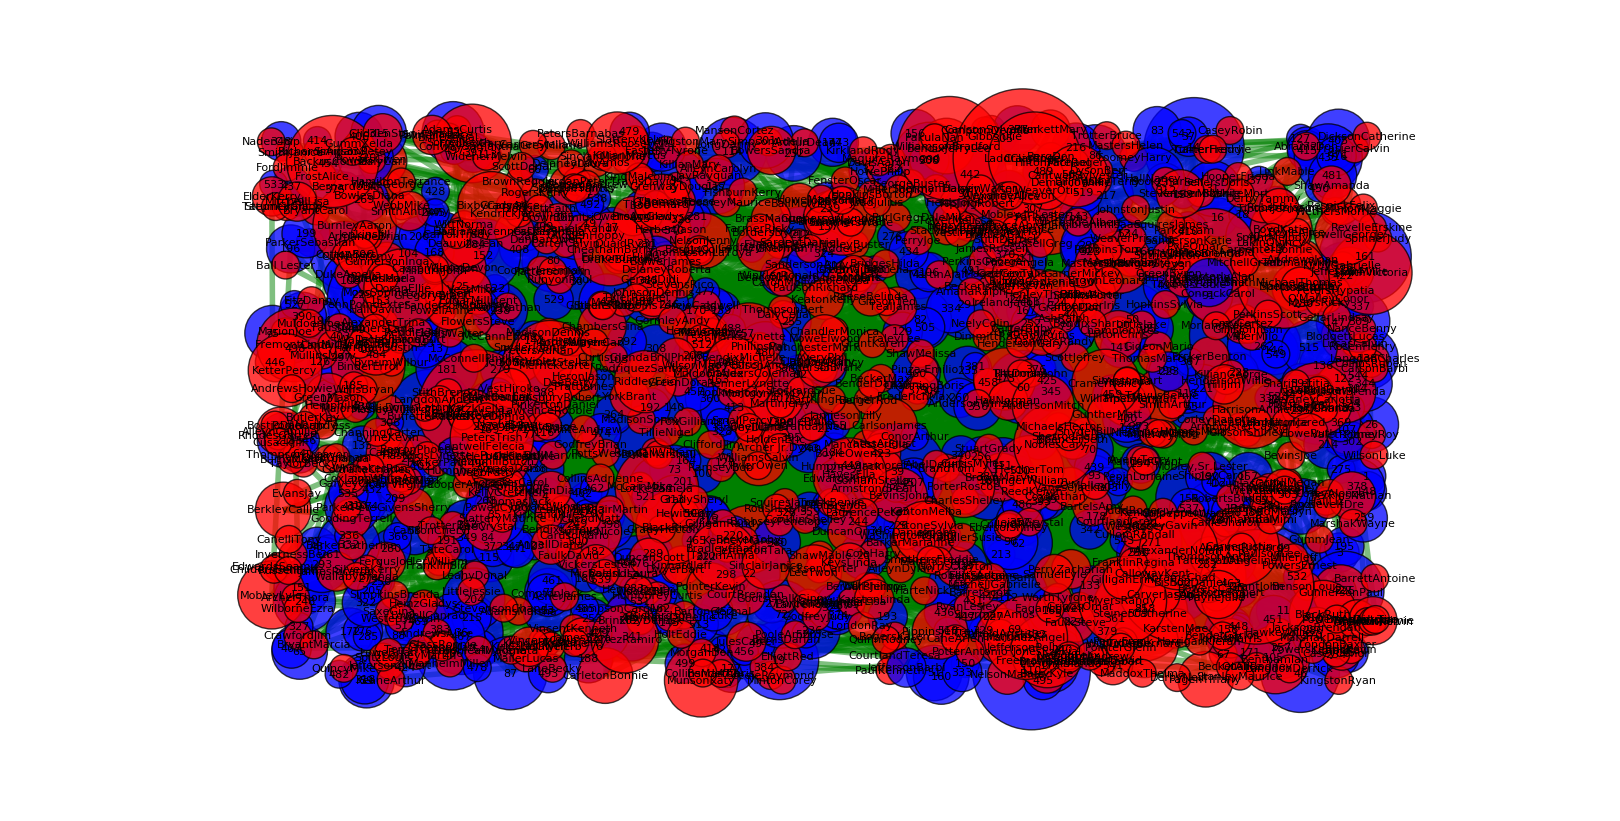

In [18]:
## plot the overall network
pos=nx.random_layout(G2) # positions for all nodes

## elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['Count'] > 10]
## esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['Count'] <= 10]

colors=[]
for n in G2.degree().keys():
    if n in G2.degree(top_nodes).keys():
        colors.append('r')
    else:
        colors.append('b')

# nodes
d = G2.degree()
nx.draw_networkx_nodes(G2,pos, node_color=colors, node_size=[v*400 for v in d.values()], alpha=0.75)

# edges
nx.draw_networkx_edges(G2,pos, width=4,alpha=0.5,edge_color='g',style='solid')
#nx.draw_networkx_edges(G2,pos,edgelist=esmall, width=2,alpha=0.2,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(G2, pos, font_size=8, font_family='sans-serif')

plt.axis('off')
plt.show()

## 3. Bipartite Projection – Person

### 3.1 Island Analysis – Persons

We adapt the island method from Tsvetovat, et al, after creating a weighted bipartite graph. Weights are the number of shared neighbors for an edge. First we isolate the biggest component of the bipartite graph, then we apply the island method and print the threshold level, the size of the graph, and the number of connected components.

In [19]:
## SNAFS: get a sorted degree list to obtain topmost nodes
def sorted_map(map):
    ms = sorted(map.iteritems(), key=lambda (k,v) : (-v, k))
    return ms

## Implementing the Island Method to look for important subgroups. ##
def trim_edges(g, weight = 1):
    # Implements a trimming of the graph edges for the Island Analysis
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,edata)
    return g2

def island_method(g, iterations = 5):
    # Iterates through the graph removing edges and returning the number of edges removed and
    #  the trimmed graph
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

### 3.2 Island method results

A threshold value of 2 results in a network of 28 Persons and 12 connected components. Of particular interest are suspect nodes connected to Luella Katz, the most-connected suspect in the graph with a degree centrality of 51. Katz is also connected to two other high-degree suspects, Michael Thomas Smith (33 degrees) and Catherine Steiner (29). Both are in the top 10 list of suspects by degree centrality.

In [20]:
PC = nx.bipartite.weighted_projected_graph(G2, top_nodes)
cc = list(nx.connected_component_subgraphs(PC))[0]

In [21]:
## Running the Island Analysis on the graph. Will throw an error if the island_method is called with too many steps
islands = island_method(cc, iterations = 4)
print ''
print 'Threshold |  Size (Persons)  |  Connected Components'
print '-----------------------------------------------------'
for island in islands:
    print('   %d               %2d                   %2d' 
          %(island[0], len(island[1]), len(list(nx.connected_component_subgraphs(island[1]))))) 


Threshold |  Size (Persons)  |  Connected Components
-----------------------------------------------------
   1               89                   27
   2               28                   12
   3               15                    7
   4                6                    3


In [22]:
# sorted(zip(cc.degree(suspects).values(), cc.degree(suspects).keys()), reverse=True)[:9]

### 3.3 Plot of network at threshold 2

Luella Katz is connected to four other suspects: Michael Smith, Catherine Steiner, Justin Johnson and Chris Bender.

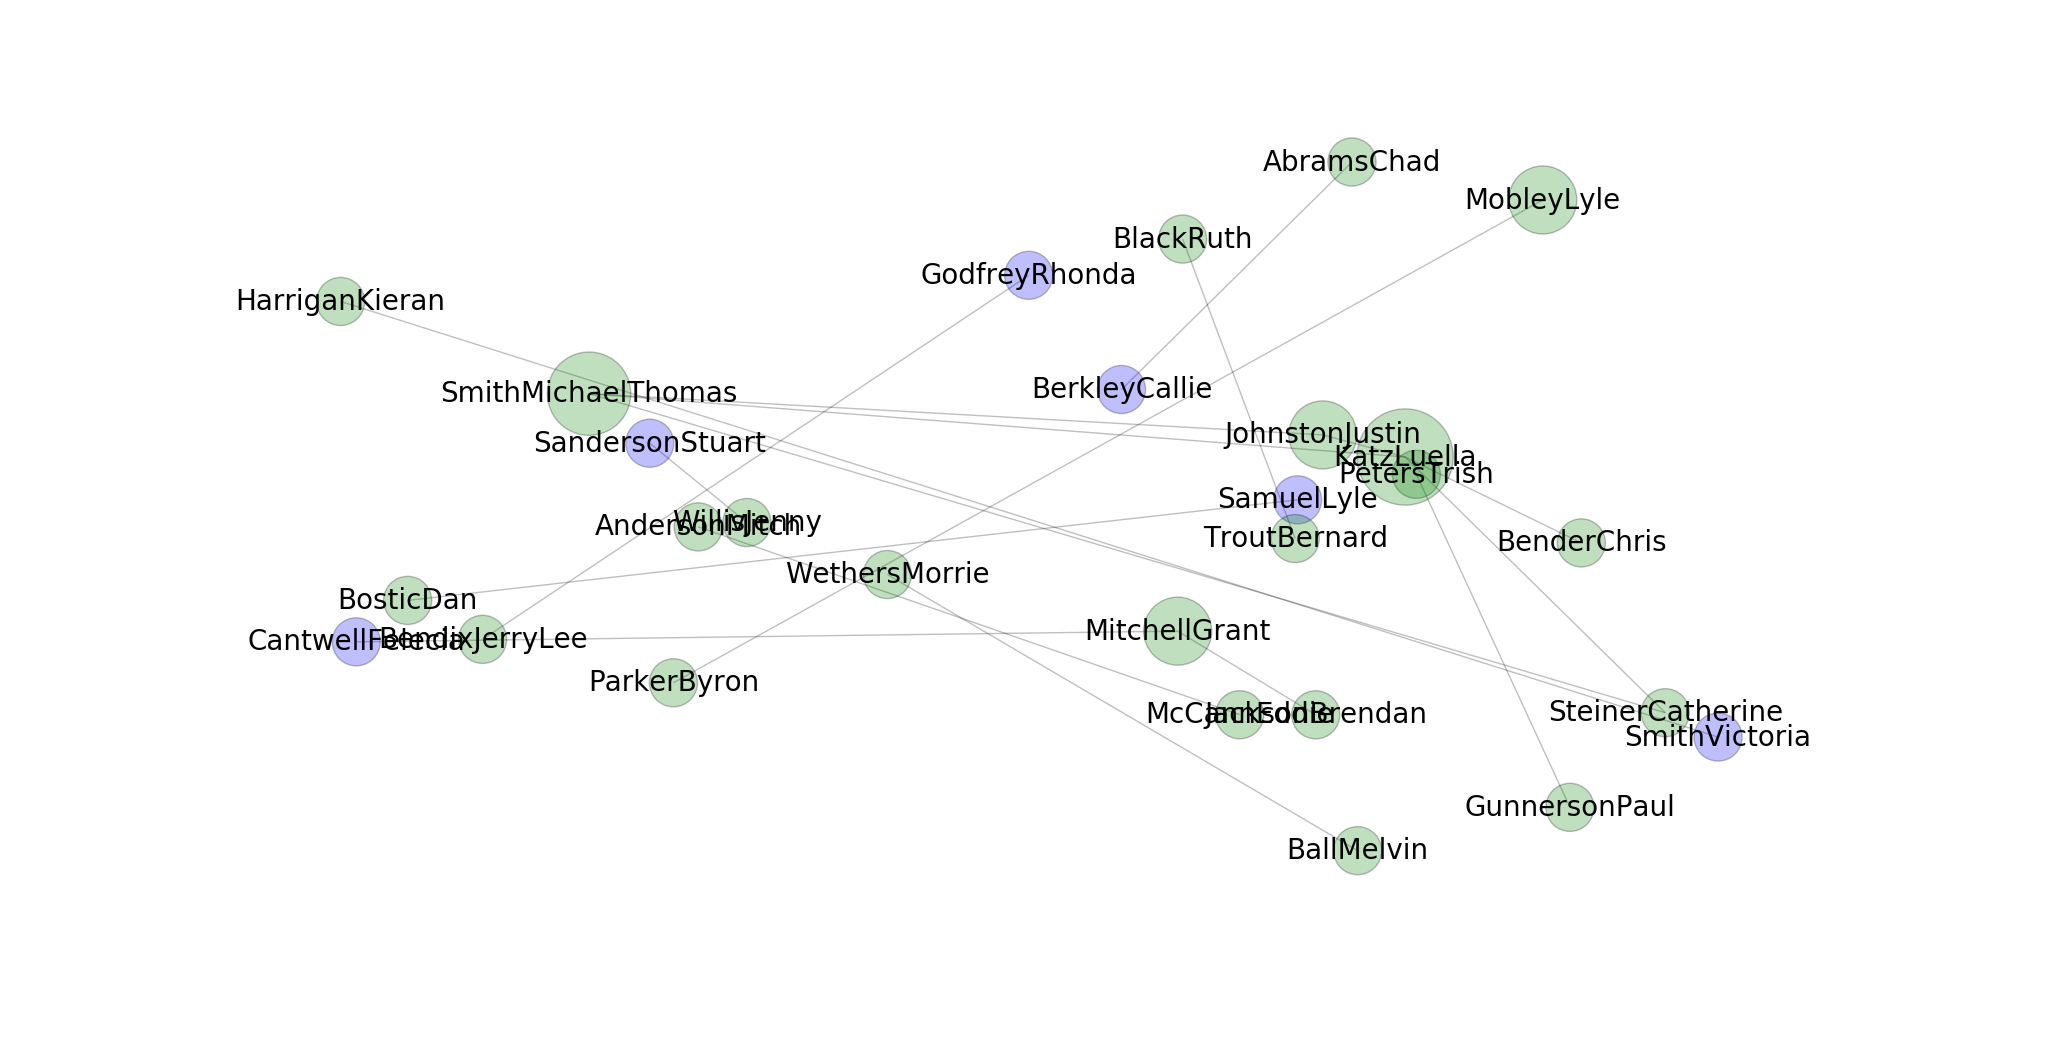

In [23]:
## Plotting created by the island analysis
pc = trim_edges(cc, 2)

nodecolors=[]
for n in pc.degree(top_nodes).keys():
    if n in suspects:
        nodecolors.append('g')
    elif n in victims:
        nodecolors.append('b')
    else:
        nodecolors.append('y')

dpc = pc.degree()
nx.draw_random(pc, node_size=[v*1200 for v in dpc.values()], with_labels=True, node_color=nodecolors, 
               alpha=.25, font_size=20)

In [24]:
# sorted(zip(pc.degree(suspects).values(), pc.degree(suspects).keys()), reverse=True)[:9]

In [25]:
# sorted(zip(cc.degree(suspects).values(), cc.degree(suspects).keys()), reverse=True)[:]

### 3.4 Luella Katz ego network

Katz is connected to 51 other persons. Those persons are listed as suspects in 40 crimes and victims in 22 crimes. 

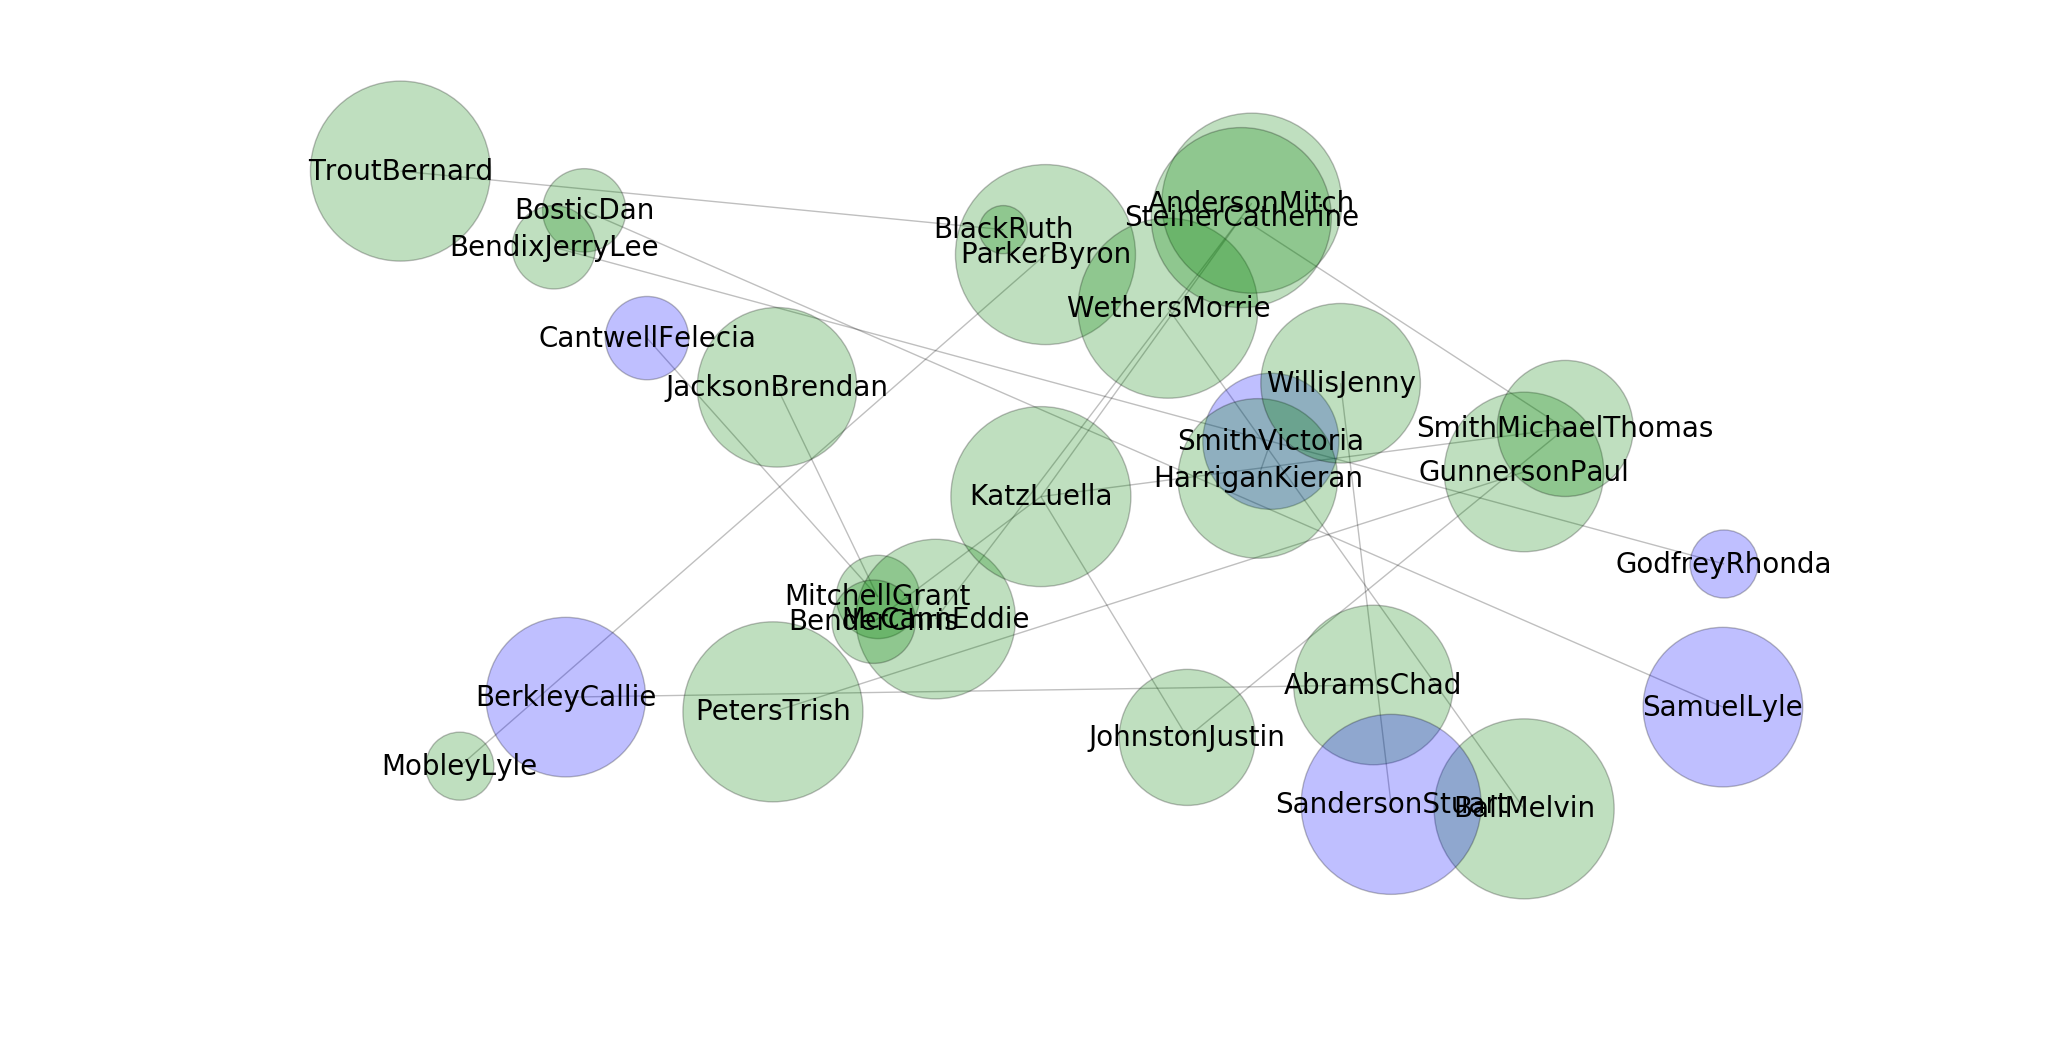

In [26]:
katz = nx.ego_graph(PC, 'KatzLuella', radius=1, center=True, undirected=True, distance='weight')

nodecolors=[]
for n in pc.degree(top_nodes).keys():
    if n in suspects:
        nodecolors.append('g')
    elif n in victims:
        nodecolors.append('b')
    else:
        nodecolors.append('y')

dkatz = katz.degree()
nx.draw_random(pc, node_size=[v*1200 for v in dkatz.values()], with_labels=True, node_color=nodecolors, 
               alpha=.25, font_size=20)

In [27]:
luella_katz = crime2[crime2['Person']=='KatzLuella']
katz_connections = pd.DataFrame(cc.edges('KatzLuella'))
katz_con = set(katz_connections.iloc[:,1])
a = len(katz_con.intersection(victims))
b = len(katz_con.intersection(suspects))

print ''
print 'Luella Katz'
print '------------------------'
print 'Victim connections:  ', a
print 'Suspect connections: ', b
print ''


Luella Katz
------------------------
Victim connections:   22
Suspect connections:  40



## 4.  Bipartite Projection, Crimes

In [28]:
# project bipartite graph onto crime nodes
# now the degrees are their connections with other crimes
# based on involvment by the same persons

CC = nx.bipartite.weighted_projected_graph(G2, bottom_nodes)

### 4.1 Island Analysis – Crimes

The island analysis identifies a six-node network of crimes. Examination of the crimes shows they all involved Luella Katz and close associates who were suspects. Katz was a witness in crime 110 along with 14 other individuals.


In [29]:
## Running the Island Analysis on the graph. Will throw an error if the island_method is called with too many steps
islands = island_method(CC, iterations = 2)
print ''
print 'Depth  Crime  Networks'
print '----------------------'
for island in islands:
    print(' %d      %3d      %2d' 
          %(island[0], len(island[1]), len(list(nx.connected_component_subgraphs(island[1])))))


Depth  Crime  Networks
----------------------
 1      119      36
 2       10       3


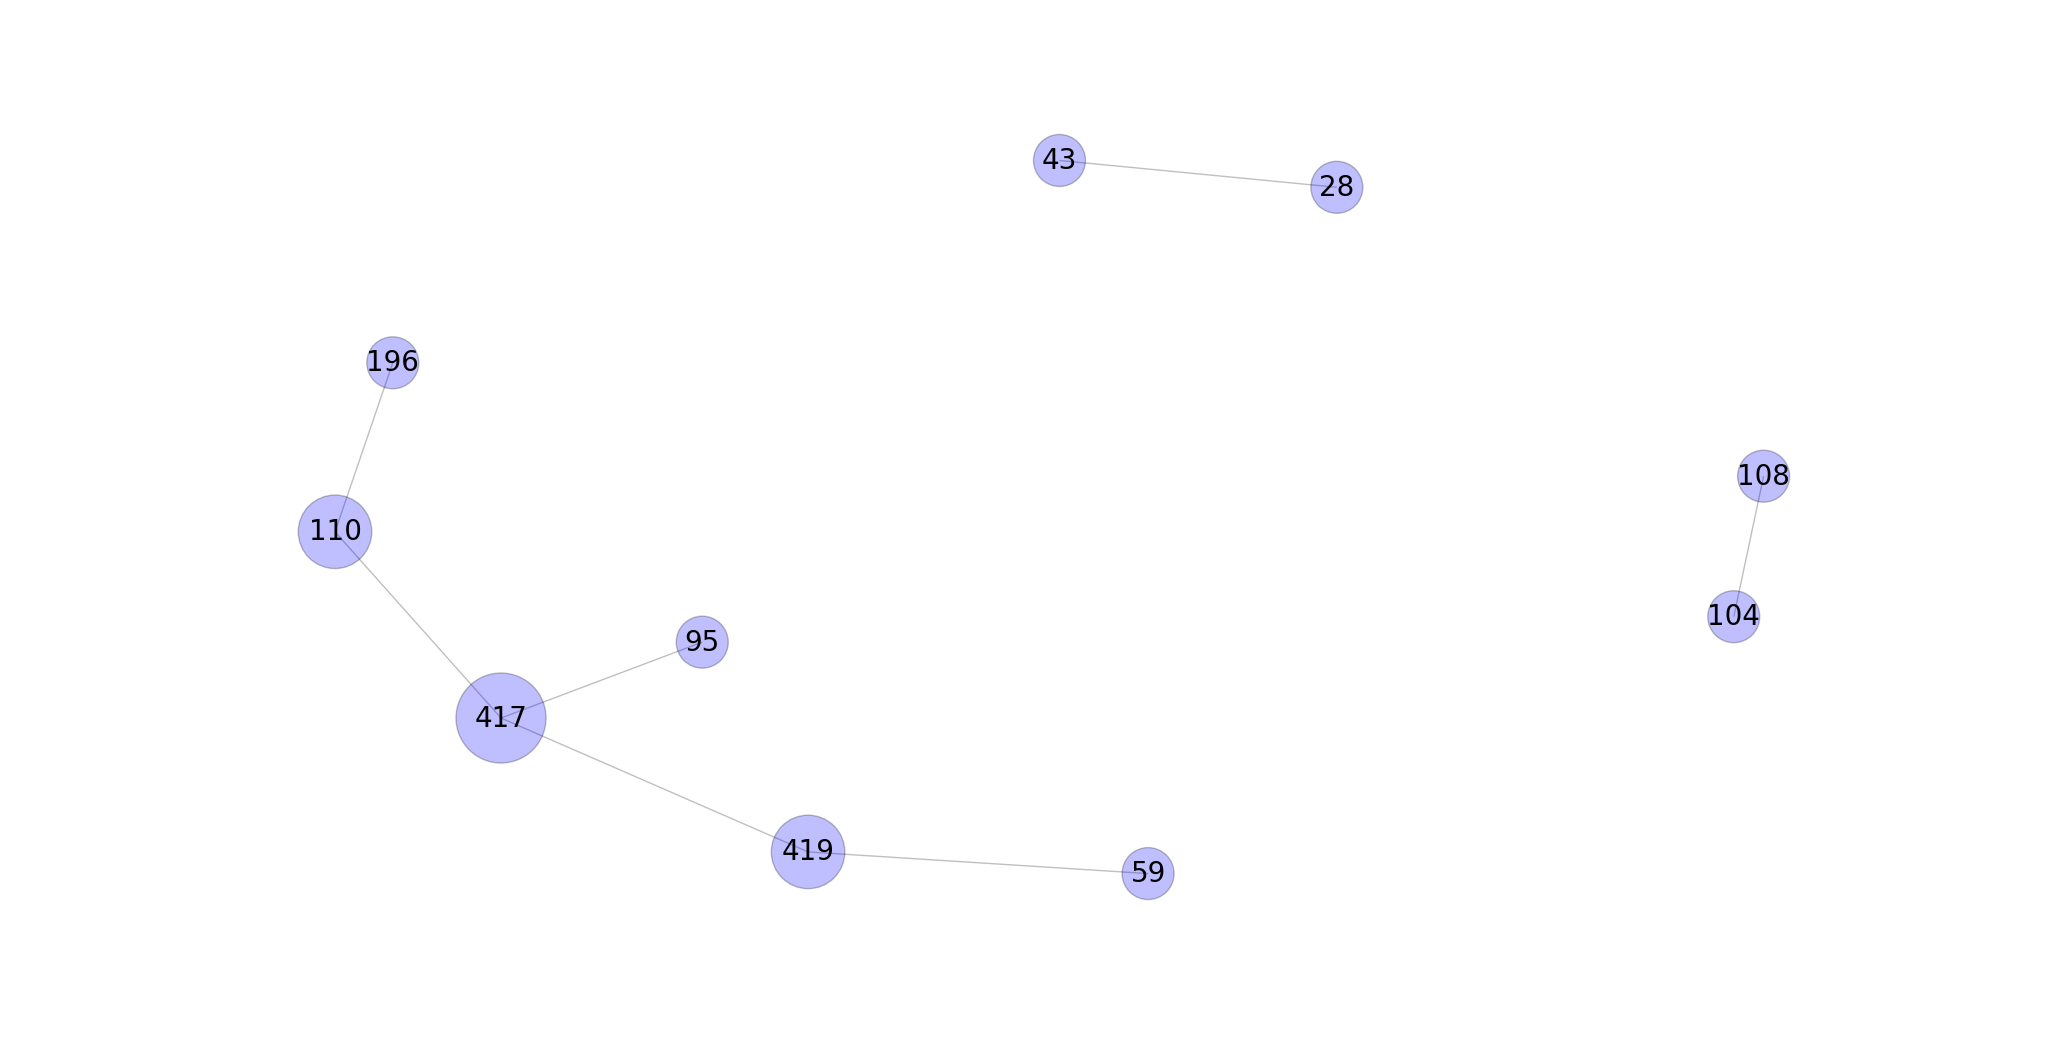

In [30]:
## Plotting the two graphs created by the island analysis
wc = trim_edges(CC, 2)
dwc = wc.degree()
nx.draw(wc, node_size=[v*1400 for v in dwc.values()], with_labels=True, node_color='b', alpha=.25, font_size=20)

In [31]:
# check the crimes
# crime_chk = crime2[crime2['Crime'] == 110]
# crime_chk

In [32]:
# check crimes and persons
# crime_chk = crime2[crime2['Person'] == 'KatzLuella']
# willis_crime = set(crime_chk['Crime'])
# katz_crime = set(crime_chk['Crime'])

## 5. Centrality Measures
In the table below we take the bipartite weighted graph and examine centrality measures. Per our visual analysis, Luella Katz's heavy involvement is confirmed; she ranks among the top 10 three centrality categories. Katz, Cathering Steiner and Michael Smith all are among the highest in eigenvector centrality – in other words, they are connected to other highly connected suspects and victims. Jenny Willis ranks high in betweenness and degree centrality. A plot of her ego network is below. Inspection shows that Willis and Katz were not involved in any of the same crimes. 

Crime 110 is of note for high betweeeness centrality: The crime involved 15 witnesses, 2 suspects and one victim.

In [33]:
## utility function to get topmost nodes for each centrality function
def get_top_keys(dictionary, top):
    items = dictionary.items()
    items.sort(reverse=True, key=lambda x: x[1])
    return map(lambda x: x, items[:top])

# Betweenness centrality
bet_cen = nx.betweenness_centrality(G2)

# Degree centrality
deg_cen = nx.degree_centrality(G2)

# Closeness centrality
clo_cen = nx.closeness_centrality(G2)

# Eigenvector centrality
eig_cen = nx.eigenvector_centrality_numpy(G2)

## get the top nodes
top_bet_cen = get_top_keys(bet_cen,10)
top_clus_cen = get_top_keys(clo_cen,10)
top_eig_cen = get_top_keys(eig_cen,10)
top_deg_cen = get_top_keys(deg_cen,10)

## smush them together to make a comparison chart
smush = np.hstack((top_bet_cen, top_clus_cen, top_eig_cen, top_deg_cen))

cent_measures=pd.DataFrame(smush, columns=['Node', 'Betweenness', 'Node', 'Closeness', 'Node', 
                                           'Eigenvector', 'Node', 'Degree'])

#### Table 1. Centrality measures compared

In [34]:
cent_measures

,Node,Betweenness,Node,Closeness,Node,Eigenvector,Node,Degree
0,WillisJenny,0.371301340152,47,0.10459398284,110,0.414920959003,WillisJenny,0.0181290790428
1,110,0.323802413821,SlatteryMaurice,0.10430116125,KatzLuella,0.414200419934,AbramsChad,0.0159535895577
2,SlatteryMaurice,0.254167041696,160,0.104197650534,SteinerCatherine,0.247706311047,110,0.0130529369108
3,23,0.252747859036,WillisJenny,0.104075584259,95,0.233381396842,KatzLuella,0.0130529369108
4,160,0.240850998043,23,0.10406620639,SmithMichaelThomas,0.220285657781,DicksonCarter,0.0123277737491
5,47,0.218627557343,AbramsChad,0.102962178704,417,0.183387969713,153,0.0108774474257
6,AbramsChad,0.189192601022,SteinerCatherine,0.102070416131,419,0.153482741794,BendixJerryLee,0.010152284264
7,46,0.178797977496,HemphillBud,0.101675038165,43,0.149970388001,14,0.00942712110225
8,14,0.168593116917,KarstenMae,0.101639246548,JohnstonJustin,0.142369334492,43,0.00942712110225
9,SteinerCatherine,0.156776034373,14,0.101416118592,MitchellGrant,0.138807303369,95,0.00942712110225


### 4.2 Jenny Willis ego network

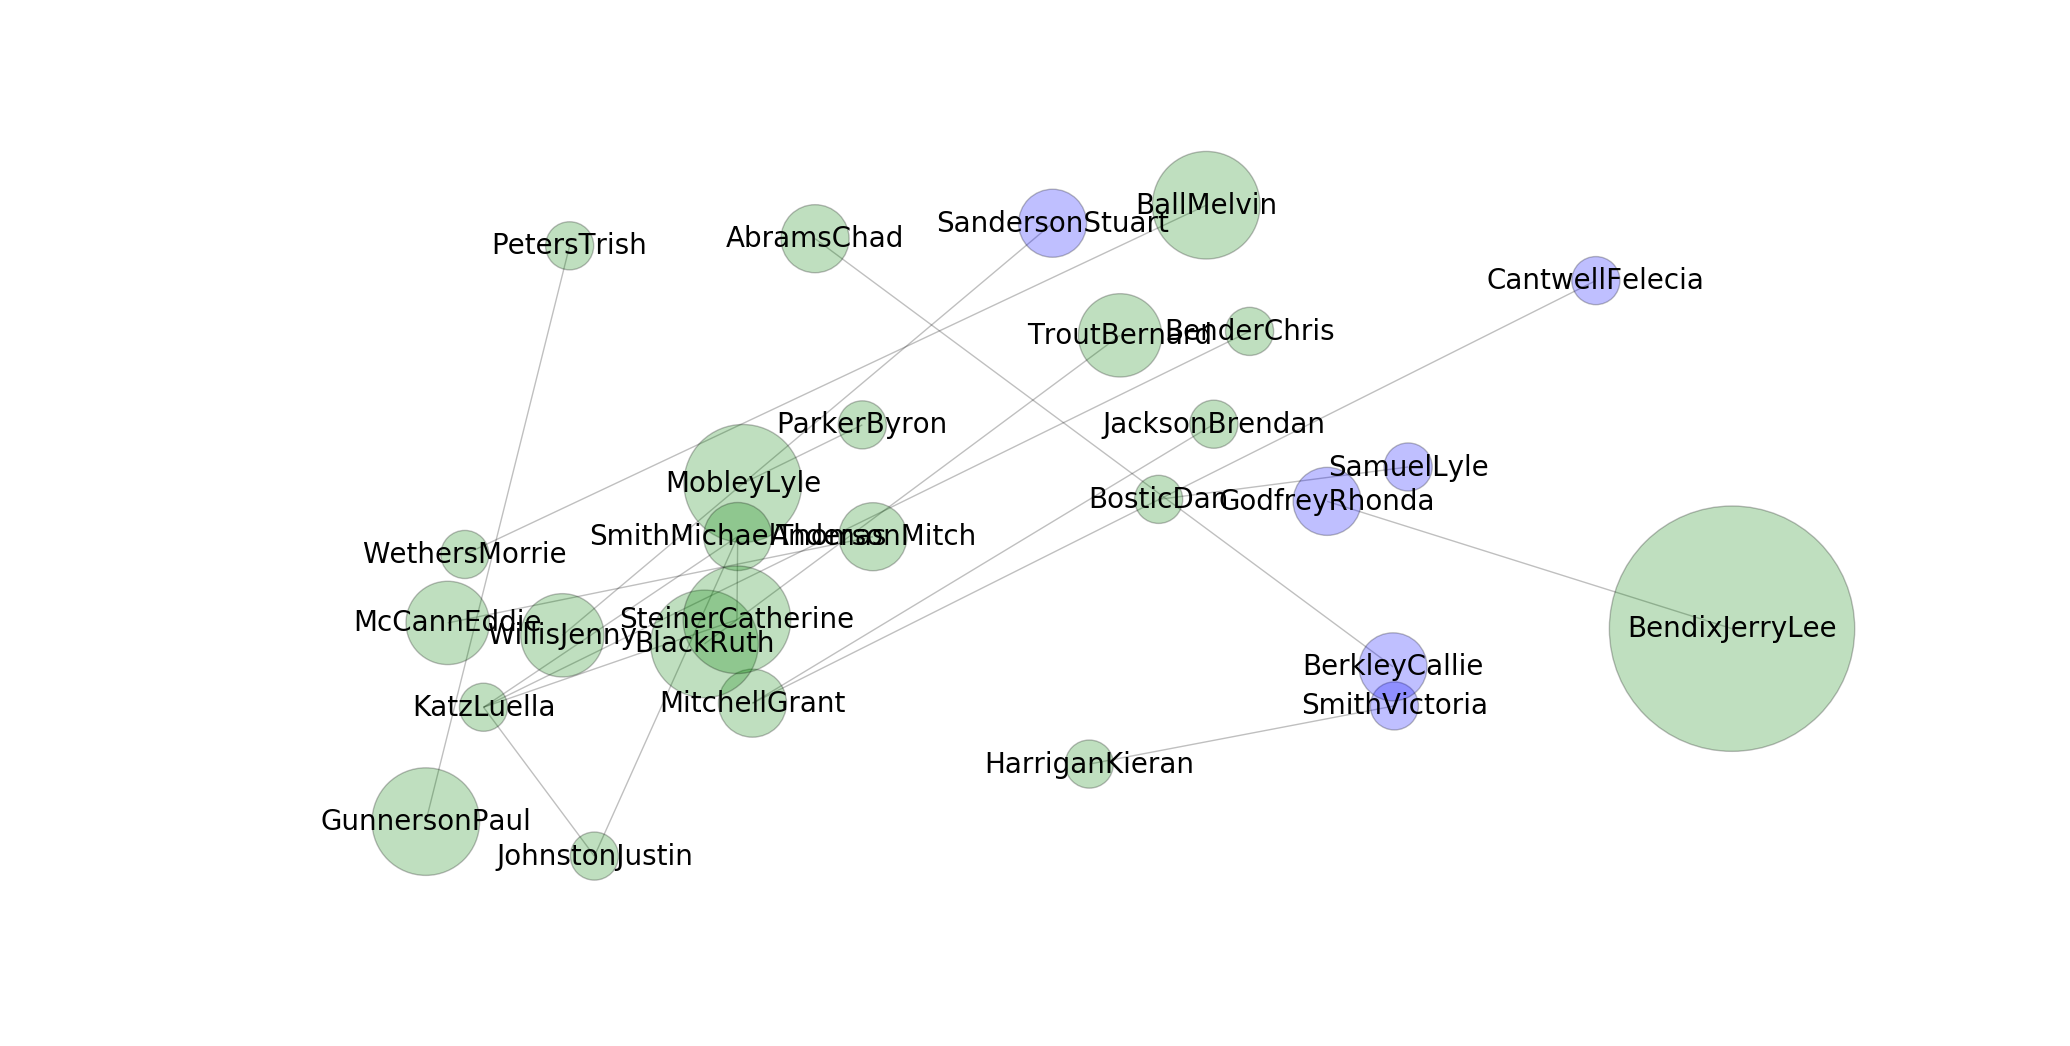

In [35]:
willis = nx.ego_graph(PC, 'WillisJenny', radius=1, center=True, undirected=True, distance='weight')

nodecolors=[]
for n in pc.degree(top_nodes).keys():
    if n in suspects:
        nodecolors.append('g')
    elif n in victims:
        nodecolors.append('b')
    else:
        nodecolors.append('y')

dwillis = willis.degree()
nx.draw_random(pc, node_size=[v*1200 for v in dwillis.values()], with_labels=True, node_color=nodecolors, 
               alpha=.25, font_size=20)